In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from sklearn.metrics import roc_auc_score

In [2]:
# reading the data
df_heart=pd.read_csv('data/framingham.csv')
#df_heart.replace(np.nan,"NaN")
df_heart.dropna(axis=0,inplace=True)

##separation in X and y
X_heart = df_heart.drop( columns = "TenYearCHD" )
y_heart = df_heart[ "TenYearCHD" ]

In [17]:
##let's start by splitting the data into a train and a validaiton set
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_heart, y_heart, stratify=y_heart, random_state=94 , train_size=0.8)
y_train.shape , y_valid.shape

((2926,), (732,))

In [18]:
%%time 
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2)

xgb_model.fit(X_train, y_train)

roc_auc_score(y_train , xgb_model.predict_proba( X_train )[:,1] ) , roc_auc_score(y_valid , xgb_model.predict_proba( X_valid )[:,1] )

CPU times: user 478 ms, sys: 0 ns, total: 478 ms
Wall time: 87.9 ms


(0.999985534500217, 0.6725856291073683)

# "basic" usage 

In [19]:
from hyperopt import hp, fmin, tpe, rand, pyll, STATUS_OK, STATUS_FAIL, Trials, space_eval


## function to optimize

We need to write a function which :
 * takes a dictionary of parameters as arguments
 * returns a dictionnary containing the computed loss and a status value
 
Importantly, the loss is a value which we want to **minimize**, so in our case we will
use -AUC(validation data)

In [24]:

def hyperopt_xgb_train( params ):
    
    xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **params)
    xgb_model.fit(X_train, y_train)
    
    loss = -roc_auc_score(y_valid , xgb_model.predict_proba( X_valid )[:,1] )
    return_dict = {'loss': loss,
                   'status': STATUS_OK
                   }
    return return_dict


In [103]:
params = dict( n_estimators=100,
               eta = 0.3,
               subsample = 0.8,
               max_depth = 5)
hyperopt_xgb_train( params )

{'loss': -0.6568017292654974, 'status': 'ok'}

## parameter search-space

The way it works is that for each hyper-parameter you define a **prior distribution** (it is bayesian afterall) using one of hyperopt function.

For a more detailed documentation we refer you to the [hyperopt documentation](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)

In [28]:
simple_uniform = hp.uniform('simple', 0, 1)
simple_uniform

In [35]:
pyll.stochastic.sample(simple_uniform)

0.6278585155287327

In [43]:
md = pyll.scope.int(hp.quniform('max_depth', 1, 16, 1))
pyll.stochastic.sample(md)

11

In [119]:
eta = hp.loguniform('eta' , np.log(10**-4) , np.log(10**2) )
pyll.stochastic.sample(eta)

0.00042375006202035627

<Axes: ylabel='Count'>

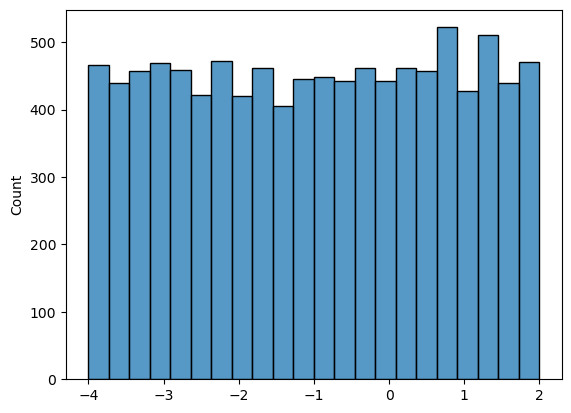

In [122]:
sns.histplot( [ np.log10( pyll.stochastic.sample(eta) ) for _ in range(10000) ] )

**exercise** : which prior distribution could we give `n_estimators`?

12

In [123]:


space4xgb = {
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 1 , 1000,1)),
    'eta': hp.loguniform('eta' , np.log(10**-4) , np.log(10**2) ),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 1, 16, 1)),
    'subsample': hp.uniform('subsample', 0.3, 1)
}

## minimizing

In [149]:
%%time
trials = Trials()

best = fmin(hyperopt_xgb_train, 
            space4xgb, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68trial/s, best loss: -0.7337047192119657]
CPU times: user 2min 41s, sys: 911 ms, total: 2min 42s
Wall time: 27.2 s


In [150]:
best

{'eta': 0.0070531424724613505,
 'max_depth': 1.0,
 'n_estimators': 988.0,
 'subsample': 0.35971798767183444}

In [151]:
len( trials )

100

In [153]:
trials.results[:10]

[{'loss': -0.6656366511438975, 'status': 'ok'},
 {'loss': -0.5, 'status': 'ok'},
 {'loss': -0.5432026229127678, 'status': 'ok'},
 {'loss': -0.6868027447737592, 'status': 'ok'},
 {'loss': -0.7132349741045394, 'status': 'ok'},
 {'loss': -0.5, 'status': 'ok'},
 {'loss': -0.61930045988017, 'status': 'ok'},
 {'loss': -0.6957102029565797, 'status': 'ok'},
 {'loss': -0.7231289260274767, 'status': 'ok'},
 {'loss': -0.7181674428051239, 'status': 'ok'}]

In [163]:
trials.losses()[:10]

[-0.6656366511438975,
 -0.5,
 -0.5432026229127678,
 -0.6868027447737592,
 -0.7132349741045394,
 -0.5,
 -0.61930045988017,
 -0.6957102029565797,
 -0.7231289260274767,
 -0.7181674428051239]

In [154]:
trials.vals.keys()

dict_keys(['eta', 'max_depth', 'n_estimators', 'subsample'])

In [156]:
for k in trials.vals.keys():
    print(k , trials.vals[k][:5])

eta [25.58707901911184, 5.499331583193347, 8.527319439829816, 0.03301508587710734, 0.0022615972016598526]
max_depth [3.0, 7.0, 6.0, 15.0, 8.0]
n_estimators [713.0, 787.0, 449.0, 213.0, 123.0]
subsample [0.5098858239800297, 0.5879951639225276, 0.6952154034678618, 0.47350835505938266, 0.7481075381421294]


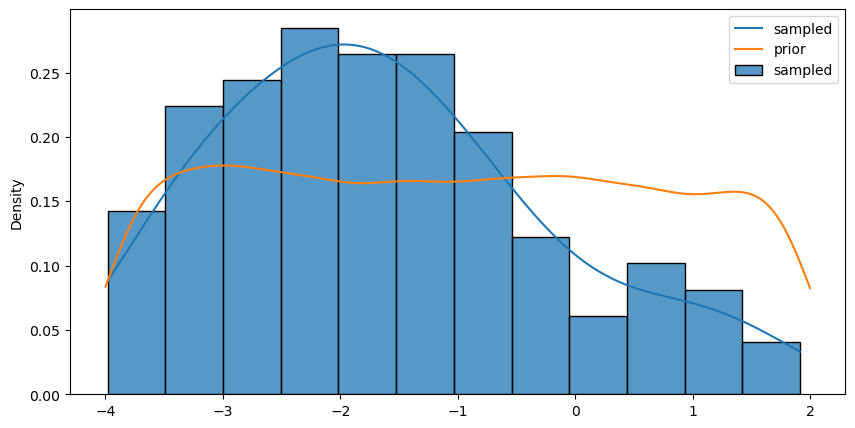

In [160]:
fig,ax = plt.subplots(figsize=(10,5))

sns.kdeplot( np.log10( trials.vals['eta'] ) , ax=ax , cut = 0 , label='sampled')
sns.histplot( np.log10( trials.vals['eta'] ) , binwidth=0.5 , ax=ax , label='sampled' , stat = 'density')

sns.kdeplot( [ np.log10( pyll.stochastic.sample(eta) ) for _ in range(10000) ] , ax=ax , cut = 0 , label='prior')
ax.set_xlabel('eta')
ax.legend()

Text(0, 0.5, 'loss')

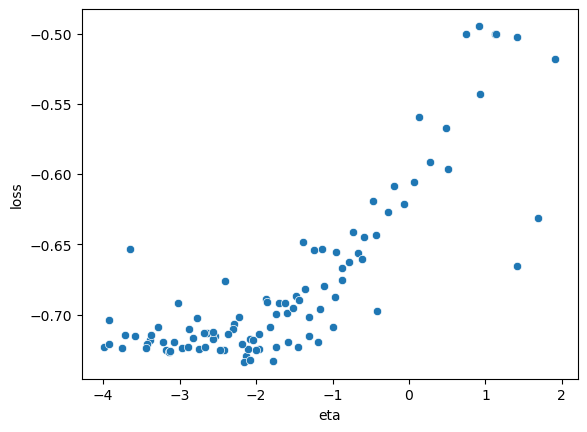

In [167]:

ax = sns.scatterplot( x = np.log10( trials.vals['eta'] ) ,
                 y =  trials.losses() )
ax.set_xlabel('eta')
ax.set_ylabel('loss')

Text(0, 0.5, 'loss')

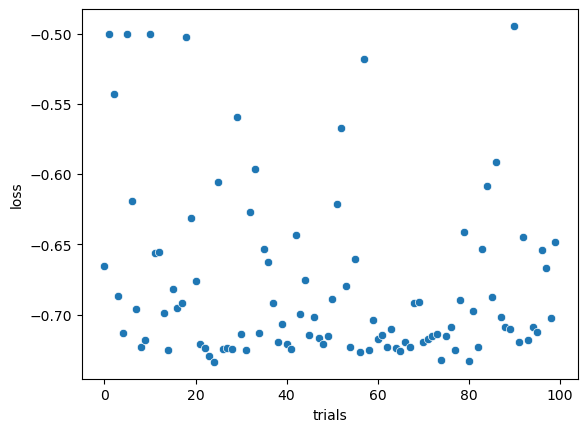

In [169]:
ax = sns.scatterplot( x =  range(len(trials.losses())) ,  y =  trials.losses() )
ax.set_xlabel('trials')
ax.set_ylabel('loss')

# changing the cross-validation scheme

In [172]:
from sklearn.model_selection import StratifiedKFold

In [181]:
skf = StratifiedKFold(n_splits=5 , shuffle=True , random_state = 2024 )
for t,v in skf.split( X_heart , y_heart ):

    print(len(t), t[:5])
    print(len(v), v[:5])

2926 [0 1 3 4 5]
732 [ 2 26 34 37 43]
2926 [0 1 2 4 5]
732 [ 3  7  8 14 15]
2926 [0 1 2 3 4]
732 [ 6 10 12 13 16]
2927 [0 2 3 6 7]
731 [ 1  4  5  9 23]
2927 [1 2 3 4 5]
731 [ 0 11 20 22 31]


In [202]:
from sklearn.model_selection import cross_val_score
cross_val_score( xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2) , 
                X_heart , y_heart, scoring = 'roc_auc' , cv = skf )

array([0.5970028 , 0.63060196, 0.68068836, 0.60491136, 0.64751526])

### exercise

Write the function we will give to `fmin` to evaluate an XGBoost classifier with 5-fold CV with a ROC AUC score.


In [203]:
## tentative solution
def hyperopt_xgb_train_CV5( params ):
    
    losses = -1 * cross_val_score( xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **params) , 
                X_heart , y_heart, scoring = 'roc_auc' , cv = skf )
        
    return_dict = {'loss': np.mean(losses),
                   'loss_variance' : np.var(losses),
                   'status': STATUS_OK
                   }
    return return_dict


In [204]:
params = dict( n_estimators=100,
               eta = 0.3,
               subsample = 0.8,
               max_depth = 5)
hyperopt_xgb_train_CV5( params )

{'loss': -0.6374179302273623,
 'loss_variance': 0.0007875657048112409,
 'status': 'ok'}

In [205]:
%%time
trials = Trials()

best = fmin(hyperopt_xgb_train_CV5, 
            space4xgb, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/trial, best loss: -0.7227249364379741]
CPU times: user 12min 59s, sys: 3.89 s, total: 13min 3s
Wall time: 2min 10s


# warm start : continue searching for better solutions

In [206]:
best = fmin(hyperopt_xgb_train_CV5, 
            space4xgb, 
            algo=tpe.suggest, 
            max_evals=110, 
            trials=trials)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:07<00:00,  1.27trial/s, best loss: -0.7227249364379741]


# nested search space

It is possible nest elements in `hp.choice()` or `hp.pchoice()` to specify more complex search spaces:

In [208]:
space4nested = hp.pchoice('classifier_type',
                          [(0.6, {'type': 'xgboost',
                                    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 1 , 1000,1)),
                                    'eta': hp.loguniform('eta' , np.log(10**-4) , np.log(10**2) ),
                                    'max_depth': pyll.scope.int(hp.quniform('max_depth', 1, 16, 1)),
                                    'subsample': hp.uniform('subsample', 0.3, 1)
                                  }
                            ),
                           (0.4, {'type': 'logistic regression',
                                  'C': hp.loguniform("C", low=np.log(1e-5), high=np.log(1e2)),
                                  'penalty': hp.choice('penalty', ['l1','l2'])
                                  }
                            )]
                          )

In [230]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def hyperopt_complex_train_CV5( params ):
    
    classif_type = params.pop('type')
    
    model = None
    if classif_type == 'xgboost':
        model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **params) 
    
    else:
        model =Pipeline([('scalar',StandardScaler()), 
                      ('model',LogisticRegression(solver ='liblinear', class_weight='balanced', **params))])
    
    losses = -1 * cross_val_score( model  , 
                    X_heart , y_heart, scoring = 'roc_auc' , cv = skf )
        
    return_dict = {'loss': np.mean(losses),
                   'loss_variance' : np.var(losses),
                   'status': STATUS_OK
                   }
    return return_dict


In [231]:
%%time
trials = Trials()
best = fmin(hyperopt_complex_train_CV5, 
            space4nested, 
            algo=tpe.suggest, 
            max_evals=50, 
            trials=trials)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.99trial/s, best loss: -0.7293318881978887]
CPU times: user 2min 22s, sys: 708 ms, total: 2min 22s
Wall time: 25.2 s


Text(0, 0.5, 'loss')

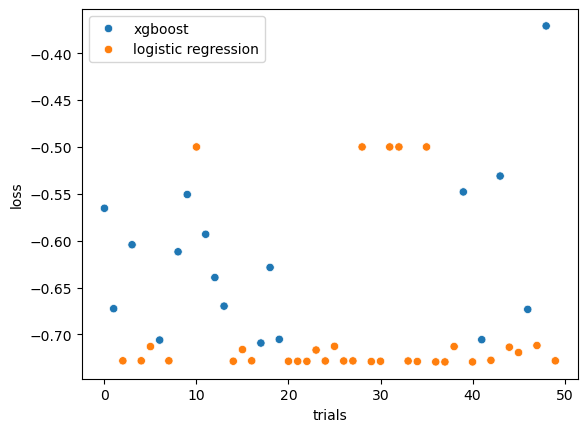

In [232]:
ax = sns.scatterplot( x =  range(len(trials.losses())) ,  y =  trials.losses() , 
                     hue = np.array(['xgboost','logistic regression'])[trials.vals['classifier_type']] )
ax.set_xlabel('trials')
ax.set_ylabel('loss')